# Customer Prediction

Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. First, we verify our model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. Then, we'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## Import Libraries

In [25]:
import numpy as np
import pandas as pd

from joblib import dump, load

from time import time
from collections import OrderedDict, Counter

from tqdm.auto import tqdm, trange
tqdm.pandas()

from utils.transformers import *
from utils.functions import *

import pyarrow

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks, ClusterCentroids
from imblearn.combine import SMOTETomek

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# magic word for producing visualizations in notebook
%matplotlib inline

## Load the Data

### Mailout Train

In [2]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


### Mailout Test

In [3]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


## Preprocessing

Load the preprocessing pipeline

In [4]:
clean_pipeline = load('temp/preprocessing_pipeline.joblib') 

We need to know the column names (after preprocessing)

In [5]:
azdias = pd.read_parquet('temp/azdias_processed.gzip')
all_features = azdias.columns
del azdias

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


### Mailout Train

In [6]:
extra_columns = ['RESPONSE']
mailout_train_extra = mailout_train[extra_columns  + ['LNR']]
mailout_train = mailout_train.drop(extra_columns, axis=1)
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3


Preprocess the `mailout_train` dataset

In [7]:
mailout_train = clean_pipeline.transform(mailout_train)
mailout_train = pd.DataFrame(mailout_train, columns=all_features)
mailout_train.head()

,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,...,MIN_GEBAEUDEJAHR,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,EINGEZOGENAM_HH_JAHR,EXTSEL992,VERDICHTUNGSRAUM,VK_DHT4A,VK_DISTANZ,VK_ZG11,LNR
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.359845,-0.292527,0.431332,0.048946,1.755996,-0.024077,-0.366474,-1.792139,-1.867551,1763.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.269507,-0.292527,-0.448734,-1.429498,2.955448,-0.519516,-1.830744,-1.792139,-1.867551,1771.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.584183,-0.292527,-0.448734,-0.985965,0.289999,0.719083,-0.000407,-1.148872,-1.490312,1776.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.359845,-0.292527,-0.228718,-1.429498,0.956362,0.099783,0.731728,1.102566,1.904842,1460.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.359845,-0.292527,2.704835,-1.429498,2.822176,-0.024077,-1.464676,-1.792139,-1.867551,1783.0


Reduce the memory usage

In [8]:
mailout_train_extra, _ = reduce_mem_usage(mailout_train_extra)
milout_train, _ = reduce_mem_usage(mailout_train)

Memory usage of dataframe:  0.6556243896484375  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 0.20493507385253906 MB
This is 31.26% of the initial size
Memory usage of dataframe:  224.8530731201172  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 30.073345184326172 MB
This is 13.37% of the initial size


Put back the extra columns

In [9]:
mailout_train = pd.merge(mailout_train, mailout_train_extra, how='inner', on='LNR')
mailout_train.head()

,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,...,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,EINGEZOGENAM_HH_JAHR,EXTSEL992,VERDICHTUNGSRAUM,VK_DHT4A,VK_DISTANZ,VK_ZG11,LNR,RESPONSE
0,0,1,0,0,0,0,1,0,0,0,...,-0.292527,0.431332,0.048946,1.755996,-0.024077,-0.366474,-1.792139,-1.867551,1763,0
1,0,1,0,0,0,0,1,0,0,0,...,-0.292527,-0.448734,-1.429498,2.955448,-0.519516,-1.830744,-1.792139,-1.867551,1771,0
2,1,0,0,1,0,0,0,0,0,0,...,-0.292527,-0.448734,-0.985965,0.289999,0.719083,-0.000407,-1.148872,-1.490312,1776,0
3,0,1,0,1,0,0,0,0,0,0,...,-0.292527,-0.228718,-1.429498,0.956362,0.099783,0.731728,1.102566,1.904842,1460,0
4,1,0,0,0,0,0,0,0,1,0,...,-0.292527,2.704835,-1.429498,2.822176,-0.024077,-1.464676,-1.792139,-1.867551,1783,0


Save the dataset for further usage

In [10]:
mailout_train.to_parquet('temp/mailout_train_processed.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


### Mailout Test

In [11]:
mailout_test = clean_pipeline.transform(mailout_test)
mailout_test = pd.DataFrame(mailout_test, columns=all_features)
mailout_test.head()

,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,...,MIN_GEBAEUDEJAHR,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,EINGEZOGENAM_HH_JAHR,EXTSEL992,VERDICHTUNGSRAUM,VK_DHT4A,VK_DISTANZ,VK_ZG11,LNR
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.045169,-0.292527,-0.375395,-1.429498,0.023455,2.329261,-0.366474,-0.505604,-1.113073,1754.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.359845,-0.292527,1.018042,-0.838120,1.755996,-0.519516,-0.366474,-1.792139,-1.867551,1770.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.359845,-0.292527,-0.375395,-1.429498,0.156727,1.338382,1.097796,-0.505604,-1.113073,1465.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.359845,-0.292527,-0.448734,-1.429498,-0.376363,0.719083,-0.000407,-0.505604,-1.113073,1470.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.359845,-0.292527,-0.448734,-0.542432,0.289999,-0.519516,-1.464676,-1.148872,-1.113073,1478.0


Reduce memory usage

In [12]:
mailout_test, _ = reduce_mem_usage(mailout_test)
mailout_test.head()

Memory usage of dataframe:  224.17791748046875  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 29.98304557800293 MB
This is 13.37% of the initial size


,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,...,MIN_GEBAEUDEJAHR,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,EINGEZOGENAM_HH_JAHR,EXTSEL992,VERDICHTUNGSRAUM,VK_DHT4A,VK_DISTANZ,VK_ZG11,LNR
0,1,0,0,1,0,0,0,0,0,0,...,-0.045169,-0.292527,-0.375395,-1.429498,0.023455,2.329261,-0.366474,-0.505604,-1.113073,1754
1,1,0,0,0,0,0,1,0,0,0,...,-0.359845,-0.292527,1.018042,-0.838120,1.755996,-0.519516,-0.366474,-1.792139,-1.867551,1770
2,0,1,0,0,0,0,0,0,1,0,...,-0.359845,-0.292527,-0.375395,-1.429498,0.156727,1.338382,1.097796,-0.505604,-1.113073,1465
3,0,1,0,1,0,0,0,0,0,0,...,-0.359845,-0.292527,-0.448734,-1.429498,-0.376363,0.719083,-0.000407,-0.505604,-1.113073,1470
4,0,1,0,0,0,0,1,0,0,0,...,-0.359845,-0.292527,-0.448734,-0.542432,0.289999,-0.519516,-1.464676,-1.148872,-1.113073,1478


Save the dataset for further usage

In [13]:
mailout_test.to_parquet('temp/mailout_test_processed.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


## Dimensionality Reduction & Clustering

Load the pca model

In [14]:
pca = load('temp/pca.joblib') 

Load the KMeans model

In [15]:
kmeans = load('temp/kmeans_model.joblib') 

### Mailout Train

In [16]:
extra_columns = ['LNR', 'RESPONSE']
mailout_train_extra = mailout_train[extra_columns]
mailout_train = mailout_train.drop(extra_columns, axis=1)
mailout_train_pca = pca.transform(mailout_train)
mailout_train_labels = kmeans.predict(mailout_train_pca)

In [17]:
mailout_train_pca_df = pd.DataFrame(list(mailout_train_pca), columns=[f'comp_{c+1}' for c in range(mailout_train_pca.shape[1])])
mailout_train_pca_df.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_141,comp_142,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150
0,-7.124094,-5.977910,11.683625,0.246202,-0.084807,0.930908,-0.090166,2.174882,0.496632,3.095369,...,-0.125951,-0.132665,-1.086848,-0.318667,-1.184848,0.181385,-1.470772,0.032473,-0.448720,-0.473682
1,2.243957,-9.988485,-4.454433,-2.697039,-2.344253,-1.318749,0.476535,-0.077764,1.499485,1.591040,...,-1.297550,-1.210673,0.371010,1.093055,-0.243341,-0.191273,-0.176948,-0.337642,-0.451063,0.037704
2,-2.145989,-7.570378,3.770291,-0.075294,7.806424,5.508147,4.613687,-3.954820,3.291206,-0.502802,...,0.937032,0.625674,1.552326,-0.787380,0.539749,-1.006728,-0.573590,-0.472887,-0.186911,0.077766
3,-6.059705,-11.285782,10.395215,11.461402,-2.129983,-0.598466,-2.651830,1.210764,6.373155,-3.411137,...,0.173037,0.296202,0.510740,1.310186,0.278361,-0.649131,-0.419690,-0.327314,-1.040765,0.172826
4,-4.431660,-4.766817,5.620727,6.498181,4.915549,8.508137,3.058896,0.924674,3.063698,2.509656,...,0.681064,1.352286,-0.530102,-1.115731,0.806574,-0.387544,-0.443237,1.119074,-0.185124,0.088071


In [18]:
label_df = pd.DataFrame(list(mailout_train_labels), columns=['CLUSTER_LABEL'])
label_df.head()

,CLUSTER_LABEL
0,1
1,0
2,0
3,3
4,3


In [19]:
mailout_train_dim = pd.concat([mailout_train_pca_df, label_df], axis=1)
mailout_train_dim.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_142,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,CLUSTER_LABEL
0,-7.124094,-5.977910,11.683625,0.246202,-0.084807,0.930908,-0.090166,2.174882,0.496632,3.095369,...,-0.132665,-1.086848,-0.318667,-1.184848,0.181385,-1.470772,0.032473,-0.448720,-0.473682,1
1,2.243957,-9.988485,-4.454433,-2.697039,-2.344253,-1.318749,0.476535,-0.077764,1.499485,1.591040,...,-1.210673,0.371010,1.093055,-0.243341,-0.191273,-0.176948,-0.337642,-0.451063,0.037704,0
2,-2.145989,-7.570378,3.770291,-0.075294,7.806424,5.508147,4.613687,-3.954820,3.291206,-0.502802,...,0.625674,1.552326,-0.787380,0.539749,-1.006728,-0.573590,-0.472887,-0.186911,0.077766,0
3,-6.059705,-11.285782,10.395215,11.461402,-2.129983,-0.598466,-2.651830,1.210764,6.373155,-3.411137,...,0.296202,0.510740,1.310186,0.278361,-0.649131,-0.419690,-0.327314,-1.040765,0.172826,3
4,-4.431660,-4.766817,5.620727,6.498181,4.915549,8.508137,3.058896,0.924674,3.063698,2.509656,...,1.352286,-0.530102,-1.115731,0.806574,-0.387544,-0.443237,1.119074,-0.185124,0.088071,3


In [20]:
mailout_train_proc = pd.concat([mailout_train_dim, mailout_train_extra[['RESPONSE']]], axis=1)
mailout_train_proc.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,CLUSTER_LABEL,RESPONSE
0,-7.124094,-5.977910,11.683625,0.246202,-0.084807,0.930908,-0.090166,2.174882,0.496632,3.095369,...,-1.086848,-0.318667,-1.184848,0.181385,-1.470772,0.032473,-0.448720,-0.473682,1,0
1,2.243957,-9.988485,-4.454433,-2.697039,-2.344253,-1.318749,0.476535,-0.077764,1.499485,1.591040,...,0.371010,1.093055,-0.243341,-0.191273,-0.176948,-0.337642,-0.451063,0.037704,0,0
2,-2.145989,-7.570378,3.770291,-0.075294,7.806424,5.508147,4.613687,-3.954820,3.291206,-0.502802,...,1.552326,-0.787380,0.539749,-1.006728,-0.573590,-0.472887,-0.186911,0.077766,0,0
3,-6.059705,-11.285782,10.395215,11.461402,-2.129983,-0.598466,-2.651830,1.210764,6.373155,-3.411137,...,0.510740,1.310186,0.278361,-0.649131,-0.419690,-0.327314,-1.040765,0.172826,3,0
4,-4.431660,-4.766817,5.620727,6.498181,4.915549,8.508137,3.058896,0.924674,3.063698,2.509656,...,-0.530102,-1.115731,0.806574,-0.387544,-0.443237,1.119074,-0.185124,0.088071,3,0


In [21]:
mailout_train_proc, _ = reduce_mem_usage(mailout_train_proc)

Memory usage of dataframe:  49.534929275512695  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 24.66507339477539 MB
This is 49.79% of the initial size


In [22]:
mailout_train_proc.to_parquet('temp/mailout_train_dim.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


### Mailout Test

In [23]:
extra_columns = ['LNR']
mailout_test_extra = mailout_test[extra_columns]
mailout_test = mailout_test.drop(extra_columns, axis=1)
mailout_test_pca = pca.transform(mailout_test)
mailout_test_labels = kmeans.predict(mailout_test_pca)

In [24]:
mailout_test_pca_df = pd.DataFrame(list(mailout_test_pca), columns=[f'comp_{c+1}' for c in range(mailout_test_pca.shape[1])])
mailout_test_pca_df.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_141,comp_142,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150
0,11.601075,-9.816062,7.240335,7.721172,6.135527,6.887179,-0.680425,2.521940,1.875311,2.006929,...,-1.212150,-1.327299,0.725036,0.098948,-0.313260,0.165750,-1.560511,-1.057309,0.001891,-0.373723
1,-5.434676,-3.148757,1.153348,0.942819,3.266895,0.402866,-0.732847,3.242065,-6.663521,2.611803,...,-0.758791,-0.785952,-0.122084,0.675796,-0.578299,-0.318183,0.100293,0.253485,-0.124941,-0.627760
2,-4.743776,-7.336224,4.497918,2.199510,-0.901174,-5.395058,2.979270,-4.804235,0.573323,-2.432270,...,-0.612351,0.542504,0.319042,0.314838,0.631520,0.273870,-0.113309,-0.548659,-0.617183,0.564675
3,-3.855754,-5.073868,2.792447,-5.691466,-2.313294,-2.529583,2.378230,-6.498502,-0.143488,-2.206387,...,0.719599,0.381258,-0.300728,0.343663,-0.603952,0.765298,0.337869,-1.693910,0.133173,-0.591272
4,14.552512,-6.599662,-3.988093,-1.746205,-2.860086,-4.980234,1.646868,-3.377343,-6.228120,7.415638,...,0.582306,-0.541596,-0.576679,-0.429233,1.041331,-0.563092,-0.010725,1.895332,1.231714,-0.425266


In [25]:
label_df = pd.DataFrame(list(mailout_test_labels), columns=['CLUSTER_LABEL'])
label_df.head()

,CLUSTER_LABEL
0,2
1,1
2,3
3,1
4,5


In [26]:
mailout_test_dim = pd.concat([mailout_test_pca_df, label_df], axis=1)
mailout_test_dim.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_142,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,CLUSTER_LABEL
0,11.601075,-9.816062,7.240335,7.721172,6.135527,6.887179,-0.680425,2.521940,1.875311,2.006929,...,-1.327299,0.725036,0.098948,-0.313260,0.165750,-1.560511,-1.057309,0.001891,-0.373723,2
1,-5.434676,-3.148757,1.153348,0.942819,3.266895,0.402866,-0.732847,3.242065,-6.663521,2.611803,...,-0.785952,-0.122084,0.675796,-0.578299,-0.318183,0.100293,0.253485,-0.124941,-0.627760,1
2,-4.743776,-7.336224,4.497918,2.199510,-0.901174,-5.395058,2.979270,-4.804235,0.573323,-2.432270,...,0.542504,0.319042,0.314838,0.631520,0.273870,-0.113309,-0.548659,-0.617183,0.564675,3
3,-3.855754,-5.073868,2.792447,-5.691466,-2.313294,-2.529583,2.378230,-6.498502,-0.143488,-2.206387,...,0.381258,-0.300728,0.343663,-0.603952,0.765298,0.337869,-1.693910,0.133173,-0.591272,1
4,14.552512,-6.599662,-3.988093,-1.746205,-2.860086,-4.980234,1.646868,-3.377343,-6.228120,7.415638,...,-0.541596,-0.576679,-0.429233,1.041331,-0.563092,-0.010725,1.895332,1.231714,-0.425266,5


In [27]:
mailout_test_proc = pd.concat([mailout_test_dim, mailout_test_extra[['LNR']]], axis=1)
mailout_test_proc.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,CLUSTER_LABEL,LNR
0,11.601075,-9.816062,7.240335,7.721172,6.135527,6.887179,-0.680425,2.521940,1.875311,2.006929,...,0.725036,0.098948,-0.313260,0.165750,-1.560511,-1.057309,0.001891,-0.373723,2,1754
1,-5.434676,-3.148757,1.153348,0.942819,3.266895,0.402866,-0.732847,3.242065,-6.663521,2.611803,...,-0.122084,0.675796,-0.578299,-0.318183,0.100293,0.253485,-0.124941,-0.627760,1,1770
2,-4.743776,-7.336224,4.497918,2.199510,-0.901174,-5.395058,2.979270,-4.804235,0.573323,-2.432270,...,0.319042,0.314838,0.631520,0.273870,-0.113309,-0.548659,-0.617183,0.564675,3,1465
3,-3.855754,-5.073868,2.792447,-5.691466,-2.313294,-2.529583,2.378230,-6.498502,-0.143488,-2.206387,...,-0.300728,0.343663,-0.603952,0.765298,0.337869,-1.693910,0.133173,-0.591272,1,1470
4,14.552512,-6.599662,-3.988093,-1.746205,-2.860086,-4.980234,1.646868,-3.377343,-6.228120,7.415638,...,-0.576679,-0.429233,1.041331,-0.563092,-0.010725,1.895332,1.231714,-0.425266,5,1478


In [28]:
mailout_test_proc, _ = reduce_mem_usage(mailout_test_proc)

Memory usage of dataframe:  49.50873947143555  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 24.7135591506958 MB
This is 49.92% of the initial size


In [29]:
mailout_test_proc.to_parquet('temp/mailout_test_dim.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


## Resampling Data

### Load Training Data

In [2]:
train = pd.read_parquet('temp/mailout_train_dim.gzip')
train.head()

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,CLUSTER_LABEL,RESPONSE
0,-7.124094,-5.977910,11.683625,0.246202,-0.084807,0.930908,-0.090166,2.174882,0.496632,3.095369,...,-1.086848,-0.318667,-1.184848,0.181385,-1.470772,0.032473,-0.448720,-0.473682,1,0
1,2.243957,-9.988485,-4.454433,-2.697039,-2.344253,-1.318749,0.476535,-0.077764,1.499485,1.591040,...,0.371010,1.093055,-0.243341,-0.191273,-0.176948,-0.337642,-0.451063,0.037704,0,0
2,-2.145989,-7.570378,3.770291,-0.075294,7.806424,5.508147,4.613687,-3.954820,3.291206,-0.502802,...,1.552326,-0.787380,0.539749,-1.006728,-0.573590,-0.472887,-0.186911,0.077766,0,0
3,-6.059705,-11.285782,10.395215,11.461402,-2.129983,-0.598466,-2.651830,1.210764,6.373155,-3.411137,...,0.510740,1.310186,0.278361,-0.649131,-0.419690,-0.327314,-1.040765,0.172826,3,0
4,-4.431660,-4.766817,5.620727,6.498181,4.915549,8.508137,3.058896,0.924674,3.063698,2.509656,...,-0.530102,-1.115731,0.806574,-0.387544,-0.443237,1.119074,-0.185124,0.088071,3,0


In [3]:
X = train.drop('RESPONSE', axis=1)
y = train[['RESPONSE']]

In [4]:
def customer_distribution(df, file_name='customer_distribution'):
    plt.figure(figsize=(5, 5))
    total = df.shape[0]
    ax = sns.countplot(x="RESPONSE", data=df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),
                ha="center") 
    plt.title('Distribution of customers responses', fontsize=15)
    plt.savefig(f'temp/{file_name}.png')    
    plt.show()

Let's look first at the actual situation

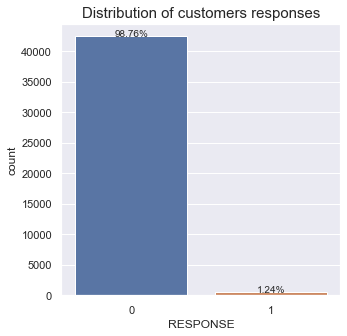

In [5]:
customer_distribution(y, 'customer_distribution_initial')

### Oversampling methods

#### SMOTE

In [6]:
resampler = SMOTE(random_state=777)
X_res, y_res = resampler.fit_sample(X, y.values.ravel())
print(X_res.shape, y_res.shape)

(84860, 151) (84860,)


In [7]:
x_df = pd.DataFrame(X_res, columns=X.columns)
y_df = pd.DataFrame(y_res, columns=y.columns)

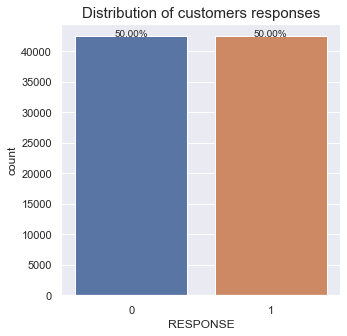

In [8]:
customer_distribution(y_df, 'customer_distribution_SMOTE')

Save for further use

In [9]:
train_smote = pd.concat([x_df, y_df], axis=1)
train_smote.to_parquet('temp/mailout_train_smote.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


#### ADASYN

In [10]:
resampler = ADASYN(random_state=777)
X_res, y_res = resampler.fit_sample(X, y.values.ravel())
print(X_res.shape, y_res.shape)

(84962, 151) (84962,)


In [11]:
x_df = pd.DataFrame(X_res, columns=X.columns)
y_df = pd.DataFrame(y_res, columns=y.columns)

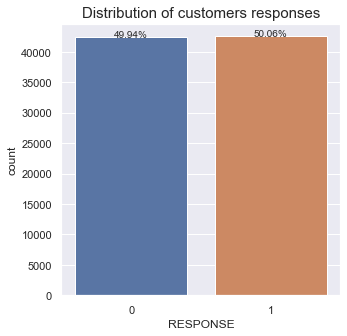

In [12]:
customer_distribution(y_df, 'customer_distribution_ADASYN')

Save for further use

In [13]:
train_adasyn = pd.concat([x_df, y_df], axis=1)
train_adasyn.to_parquet('temp/mailout_train_adasyn.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


### Undersampling methods

#### ClusterCentroids

In [14]:
kmeans = load('temp/kmeans_model.joblib') 
resampler = ClusterCentroids(estimator=kmeans, n_jobs=-1, random_state=777)
X_res, y_res = resampler.fit_sample(X, y.values.ravel())
print(X_res.shape, y_res.shape)

(1064, 151) (1064,)


In [15]:
x_df = pd.DataFrame(X_res, columns=X.columns)
y_df = pd.DataFrame(y_res, columns=y.columns)

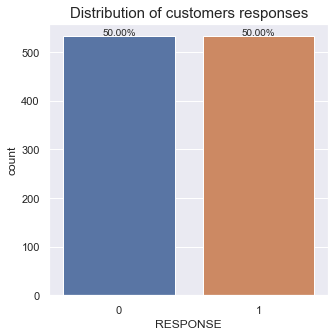

In [16]:
customer_distribution(y_df, 'customer_distribution_ClusterCentroids')

In [17]:
train_cluster_cetroids = pd.concat([x_df, y_df], axis=1)
train_cluster_cetroids.to_parquet('temp/mailout_train_cluster_centroids.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


#### TomekLinks

In [18]:
resampler = TomekLinks(n_jobs=-1, random_state=777)
X_res, y_res = resampler.fit_sample(X, y.values.ravel())
print(X_res.shape, y_res.shape)

(42848, 151) (42848,)


In [19]:
x_df = pd.DataFrame(X_res, columns=X.columns)
y_df = pd.DataFrame(y_res, columns=y.columns)

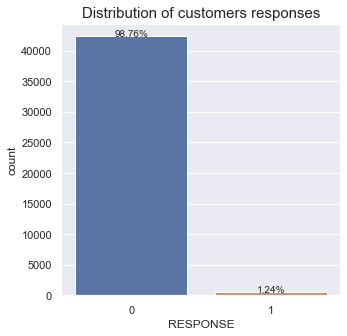

In [20]:
customer_distribution(y_df, 'customer_distribution_TomekLinks')

In [21]:
train_tomek_links = pd.concat([x_df, y_df], axis=1)
train_tomek_links.to_parquet('temp/mailout_train_tomek_links.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


### Combination 

#### SMOTETomek

In [22]:
resampler = SMOTETomek(n_jobs=-1, random_state=777)
X_res, y_res = resampler.fit_sample(X, y.values.ravel())
print(X_res.shape, y_res.shape)

(84860, 151) (84860,)


In [23]:
x_df = pd.DataFrame(X_res, columns=X.columns)
y_df = pd.DataFrame(y_res, columns=y.columns)

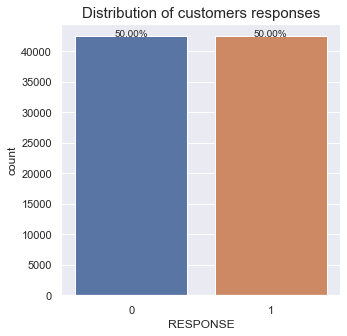

In [24]:
customer_distribution(y_df, 'customer_distribution_SMOTETomek')

In [25]:
train_smote_tomek = pd.concat([x_df, y_df], axis=1)
train_smote_tomek.to_parquet('temp/mailout_train_smote_tomek.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


## Benchmark

### No resampling

In [26]:
train = pd.read_parquet('temp/mailout_train_dim.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']
print(X.shape, y.shape)

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(42962, 151) (42962,)


In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

In [29]:
clf = LogisticRegression(solver = 'liblinear', random_state = 777)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.5


### SMOTE

In [30]:
train = pd.read_parquet('temp/mailout_train_SMOTE.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']
print(X.shape, y.shape)

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(84860, 151) (84860,)


In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

In [32]:
clf = LogisticRegression(solver = 'liblinear', random_state = 777)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.6563752062220127


### ADASYN

In [33]:
train = pd.read_parquet('temp/mailout_train_adasyn.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']
print(X.shape, y.shape)

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(84962, 151) (84962,)


In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

In [35]:
clf = LogisticRegression(solver = 'liblinear', random_state = 777)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.6584083989447794


### ClusterCentroids

In [36]:
train = pd.read_parquet('temp/mailout_train_cluster_centroids.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']
print(X.shape, y.shape)

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(1064, 151) (1064,)


In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

In [38]:
clf = LogisticRegression(solver = 'liblinear', random_state = 777)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.6955122553341562


### TomekLinks

In [39]:
train = pd.read_parquet('temp/mailout_train_tomek_links.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']
print(X.shape, y.shape)

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(42848, 151) (42848,)


In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

In [41]:
clf = LogisticRegression(solver = 'liblinear', random_state = 777)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.5


### SMOTETomek

In [42]:
train = pd.read_parquet('temp/mailout_train_smote_tomek.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']
print(X.shape, y.shape)

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(84860, 151) (84860,)


In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

In [44]:
clf = LogisticRegression(solver = 'liblinear', random_state = 777)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.6563752062220127


## Voting Classifier

### No resampling

In [46]:
train = pd.read_parquet('temp/mailout_train_dim.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

clf = VotingClassifier([('svc',SVC(gamma ='scale', random_state = 777)),
                        ('ann', MLPClassifier(random_state=777)),
                        ('knn',KNeighborsClassifier(n_neighbors=8)),
                        ('rfor',RandomForestClassifier(n_estimators=200, random_state = 777))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


ROC AUC score for training: 0.5


### SMOTE

In [47]:
train = pd.read_parquet('temp/mailout_train_SMOTE.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

clf = VotingClassifier([('svc',SVC(gamma ='scale', random_state = 777)),
                        ('ann', MLPClassifier(random_state=777)),
                        ('knn',KNeighborsClassifier(n_neighbors=8)),
                        ('rfor',RandomForestClassifier(n_estimators=200, random_state = 777))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


ROC AUC score for training: 0.9356587320292247


### ADASYN

In [48]:
train = pd.read_parquet('temp/mailout_train_adasyn.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

clf = VotingClassifier([('svc',SVC(gamma ='scale', random_state = 777)),
                        ('ann', MLPClassifier(random_state=777)),
                        ('knn',KNeighborsClassifier(n_neighbors=8)),
                        ('rfor',RandomForestClassifier(n_estimators=200, random_state = 777))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


ROC AUC score for training: 0.9364614703212208


### ClusterCentroids

In [49]:
train = pd.read_parquet('temp/mailout_train_cluster_centroids.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

clf = VotingClassifier([('svc',SVC(gamma ='scale', random_state = 777)),
                        ('ann', MLPClassifier(random_state=777)),
                        ('knn',KNeighborsClassifier(n_neighbors=8)),
                        ('rfor',RandomForestClassifier(n_estimators=200, random_state = 777))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


ROC AUC score for training: 0.8784605889613823


### TomekLinks

In [50]:
train = pd.read_parquet('temp/mailout_train_tomek_links.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

clf = VotingClassifier([('svc',SVC(gamma ='scale', random_state = 777)),
                        ('ann', MLPClassifier(random_state=777)),
                        ('knn',KNeighborsClassifier(n_neighbors=8)),
                        ('rfor',RandomForestClassifier(n_estimators=200, random_state = 777))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


ROC AUC score for training: 0.5


### SMOTETomek

In [51]:
train = pd.read_parquet('temp/mailout_train_smote_tomek.gzip')
X = train.drop('RESPONSE', axis=1)
y = train['RESPONSE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

clf = VotingClassifier([('svc',SVC(gamma ='scale', random_state = 777)),
                        ('ann', MLPClassifier(random_state=777)),
                        ('knn',KNeighborsClassifier(n_neighbors=8)),
                        ('rfor',RandomForestClassifier(n_estimators=200, random_state = 777))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


ROC AUC score for training: 0.9356587320292247


## XGBoostClassifier

### Load Training Data

In [52]:
train = pd.read_parquet('temp/mailout_train_dim.gzip')
train.head()

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,CLUSTER_LABEL,RESPONSE
0,-7.124094,-5.977910,11.683625,0.246202,-0.084807,0.930908,-0.090166,2.174882,0.496632,3.095369,...,-1.086848,-0.318667,-1.184848,0.181385,-1.470772,0.032473,-0.448720,-0.473682,1,0
1,2.243957,-9.988485,-4.454433,-2.697039,-2.344253,-1.318749,0.476535,-0.077764,1.499485,1.591040,...,0.371010,1.093055,-0.243341,-0.191273,-0.176948,-0.337642,-0.451063,0.037704,0,0
2,-2.145989,-7.570378,3.770291,-0.075294,7.806424,5.508147,4.613687,-3.954820,3.291206,-0.502802,...,1.552326,-0.787380,0.539749,-1.006728,-0.573590,-0.472887,-0.186911,0.077766,0,0
3,-6.059705,-11.285782,10.395215,11.461402,-2.129983,-0.598466,-2.651830,1.210764,6.373155,-3.411137,...,0.510740,1.310186,0.278361,-0.649131,-0.419690,-0.327314,-1.040765,0.172826,3,0
4,-4.431660,-4.766817,5.620727,6.498181,4.915549,8.508137,3.058896,0.924674,3.063698,2.509656,...,-0.530102,-1.115731,0.806574,-0.387544,-0.443237,1.119074,-0.185124,0.088071,3,0


In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

In [54]:
X_train, y_train = SMOTETomek(random_state=777).fit_sample(X_train, y_train.values.ravel())

### Train the Model

In [55]:
scorer = make_scorer(roc_auc_score)

In [62]:
# Scoring and optimization functions
def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val.values, label=y_val.values)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_val, predictions)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

In [63]:
def optimize(random_state=777):
    """
    This is the optimization function that given a space of hyperparameters and a scoring function, 
    finds the best hyperparameters.
    """
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',
        'silent': 1,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=250)
    return best

In [65]:
#best_hyperparams = optimize()
print('Optimize steps removed to reduce notebook size')
print("The best hyperparameters are: ", "\n")
print("{'colsample_bytree': 0.75, 'eta': 0.25, 'gamma': 0.5, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 673.0, 'subsample': 0.8}")
#print(best_hyperparams)

Optimize steps removed to reduce notebook size
The best hyperparameters are:  

{'colsample_bytree': 0.75, 'eta': 0.25, 'gamma': 0.5, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 673.0, 'subsample': 0.8}


In [67]:
clf = XGBClassifier(colsample_bytree=0.75,
                    eta=0.25,
                    gamma=0.5,
                    max_depth=8,
                    min_child_weight=1,
                    n_estimators=673,
                    subsample=0.8,
                    random_state = 777, 
                    tree_method='gpu_hist')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val.values)

In [68]:
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.9467358001414095


### Test the Model

Load the test data

In [75]:
test = pd.read_parquet('temp/mailout_test_dim.gzip')
test.head()

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,CLUSTER_LABEL,LNR
0,11.601075,-9.816062,7.240335,7.721172,6.135527,6.887179,-0.680425,2.521940,1.875311,2.006929,...,0.725036,0.098948,-0.313260,0.165751,-1.560511,-1.057310,0.001891,-0.373723,2,1754
1,-5.434677,-3.148757,1.153348,0.942819,3.266895,0.402866,-0.732847,3.242065,-6.663521,2.611803,...,-0.122084,0.675796,-0.578299,-0.318183,0.100293,0.253485,-0.124941,-0.627760,1,1770
2,-4.743775,-7.336224,4.497918,2.199510,-0.901174,-5.395058,2.979270,-4.804235,0.573323,-2.432271,...,0.319042,0.314838,0.631520,0.273870,-0.113309,-0.548659,-0.617183,0.564675,3,1465
3,-3.855754,-5.073868,2.792447,-5.691466,-2.313294,-2.529583,2.378230,-6.498502,-0.143488,-2.206387,...,-0.300728,0.343663,-0.603952,0.765298,0.337869,-1.693910,0.133173,-0.591272,1,1470
4,14.552512,-6.599662,-3.988093,-1.746204,-2.860086,-4.980234,1.646868,-3.377343,-6.228120,7.415637,...,-0.576679,-0.429233,1.041331,-0.563092,-0.010725,1.895332,1.231714,-0.425266,5,1478


In [79]:
submit = test[['LNR']]
X_test = test.drop('LNR',axis=1)
X_test.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_142,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,CLUSTER_LABEL
0,11.601075,-9.816062,7.240335,7.721172,6.135527,6.887179,-0.680425,2.521940,1.875311,2.006929,...,-1.327299,0.725036,0.098948,-0.313260,0.165751,-1.560511,-1.057310,0.001891,-0.373723,2
1,-5.434677,-3.148757,1.153348,0.942819,3.266895,0.402866,-0.732847,3.242065,-6.663521,2.611803,...,-0.785952,-0.122084,0.675796,-0.578299,-0.318183,0.100293,0.253485,-0.124941,-0.627760,1
2,-4.743775,-7.336224,4.497918,2.199510,-0.901174,-5.395058,2.979270,-4.804235,0.573323,-2.432271,...,0.542504,0.319042,0.314838,0.631520,0.273870,-0.113309,-0.548659,-0.617183,0.564675,3
3,-3.855754,-5.073868,2.792447,-5.691466,-2.313294,-2.529583,2.378230,-6.498502,-0.143488,-2.206387,...,0.381258,-0.300728,0.343663,-0.603952,0.765298,0.337869,-1.693910,0.133173,-0.591272,1
4,14.552512,-6.599662,-3.988093,-1.746204,-2.860086,-4.980234,1.646868,-3.377343,-6.228120,7.415637,...,-0.541596,-0.576679,-0.429233,1.041331,-0.563092,-0.010725,1.895332,1.231714,-0.425266,5


In [80]:
y_test = clf.predict(X_test.values)

In [81]:
submit['RESPONSE'] = y_test
submit.head()

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0


In [82]:
submit.to_csv('temp/capstone_submit.csv', index=False)